In [2]:
import xarray as xr
import pyPamtra
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import src
import typhon as ty

# use typhon ploting style
plt.style.use(ty.plots.styles.get('typhon'))

/net/secaire/mringel/.conda/envs/ac3env/lib/python3.10/site-packages/typhon/nonlte/rtc/__init__.py:9: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def FOSC(tau, Sb, Sm, Ib):


In [20]:
flight_id = 'ACLOUD_P5_RF04'
clearsky = True

In [21]:
def createPAMfromERA5(tmp_ds,descriptorFile,debug=False,verbosity=0,step=1,cut_levels=None,clearsky=False):
    
    """
    import ERA5 full model output from netcdf files
    
    netcdf files have been created with cdo by extracting desired timestep and lat/lon region for all variables needed and 
    converting the temperature from spherical harmonics to Gaussian linear grid. 

    2d vars: 031 034 129 134 137 151 165 166 172 235
    cdo -f nc -P $threads -seltimestep,$timestep -selday,$dd -sellonlatbox,$minlon,$maxlon,$minlat,$maxlat -setgridtype,regular gribfile ncfile
    3d vars: 075 076 133 246 247 130
    cdo -f nc -P $threads -sellonlatbox,$minlon,$maxlon,$minlat,$maxlat [-setgridtype,regular|-sp2gpl] -seltimestep,$timestep gribfile ncfile
    3d but 2d is 152 the logarithm of the surface pressure
    
    era5_datetime: yyyymmmdd_hh of the model output
    descriptorfile: ECMWF descriptorfile
    debug: switch on debugging
    verbosity: increase verbosity
    step: reduce ERA5 grid to nth point in lat/lon
    cut_levels: cut atmosphere from top. This is necessary, cause PAMTRA can not calculate gas absorption for pressure below 3hPa. 
                A sufficiently good value for cut_levels is 5.
    """

    if debug: import pdb;pdb.set_trace()

    R_d = 287.0597
    R_v = 461.5250
    R_g = 9.80665

    #tmp_ds = xr.open_dataset(inPath+'ERA5_'+flight_id+'.nc')

    # define and get 2d vars
    vals2D = dict()
    #vals2D_params = {'031':'ci','034':'sst','129':'z','134':'sp','151':'msl','165':'10u','166':'10v','172':'lsm','235':'skt'}

    indices = np.arange(0,len(tmp_ds.time),4)
    
    try: 
        tmp_ds = tmp_ds.isel(time=indices,lat_2=0,drop=True)#.squeeze()
    except:
        tmp_ds = tmp_ds.isel(time=indices,drop=True)#.squeeze()

    #for key,value in vals2D_params.items():
    #    tmp_ds = xr.open_dataset(inPath+'reduced_sf_'+era5_datetime+'_'+key+'.nc')
    #    vals2D[value] = np.squeeze(np.swapaxes(tmp_ds['var'+str(int(key))].values,1,2))[0::step,0::step]

    # get logarithm of surface pressure, a_coef, and b_coef
    #vals2D['lnsp'] = np.squeeze(np.swapaxes(tmp_ds['lnsp'].values,2,3))[0::step,0::step]
    a_coef = tmp_ds['hyai'].values[cut_levels:]
    b_coef = tmp_ds['hybi'].values[cut_levels:]

    # define and get 3d vars
    #vals3D = dict()
    #vals3D_params = {'075':'crwc','076':'cswc','130':'t','133':'q','246':'clwc','247':'ciwc'}

    #for key,value in vals3D_params.items():
    #    tmp_ds = xr.open_dataset(inPath+'reduced_ml_'+era5_datetime+'_'+key+'.nc')
    #    vals3D[value] = np.squeeze(np.swapaxes(tmp_ds[value].values,1,3)[...,cut_levels:])[0::step,0::step,::-1]
    
    # set grid size for the data
    (Nx,Ny,Nz) = (tmp_ds['t'].shape[0],1,tmp_ds['t'].shape[1]-cut_levels)
    nHydro = 4 # ERA5 has 4 hydrometeor classes

    shape2D = (Nx,Ny)
    shape3D = (Nx,Ny,Nz)
    shape3Dplus = (Nx,Ny,Nz+1)
    shape4D = (Nx,Ny,Nz,nHydro)

    # time in seconds since 1970 UTC
    unixtime = np.zeros(shape2D)
    unixtime[:] = tmp_ds['time'][0].astype(int)/ 10**9

    # create empty pamData dict
    pamData = dict()

    pamData['timestamp'] = unixtime

    # create latitude and longitude grid
    pamData['lat'] = np.zeros((Nx,1))
    pamData['lon'] = np.zeros((Nx,1))
    pamData['lat'][:,0] = tmp_ds['lat']
    pamData['lon'][:,0] = tmp_ds['lon']

    # create temperature field
    pamData['temp'] = np.empty(shape3D)
    pamData['temp'][:,0,:] = tmp_ds['t'][:,:cut_levels-1:-1]
    pamData['temp_lev'] = np.empty(shape3Dplus)
    pamData['temp_lev'][:,0,1:-1] = (pamData['temp'][:,0,1:] + pamData['temp'][:,0,0:-1])*0.5
    pamData['temp_lev'][:,0,-1] = pamData['temp_lev'][:,0,-2]+ (pamData['temp_lev'][:,0,-2] - pamData['temp_lev'][:,0,-3])*0.5
    pamData['temp_lev'][:,0,0] = tmp_ds['skt'][:]

    # height and pressure grid
    pamData['hgt'] = np.empty(shape3D)
    pamData['hgt_lev'] = np.empty(shape3Dplus)
    pamData['press'] = np.empty(shape3D)
    pamData['press_lev'] = np.empty(shape3Dplus)

    #q = tmp_ds['q'][:,:cut_levels-1:-1]

    def compute_p_level(a_coef,b_coef,sp,p_h,p_f):
        '''Return the presure  at half- (p_h) and full-levels (p_f)'''
        p_h[...,0] = a_coef[0] + (b_coef[0] * sp)
        for i in range(1,len(a_coef)):
            p_h[...,i] = a_coef[i] + (b_coef[i] * sp)
            p_f[...,i-1] = (p_h[...,i-1] + p_h[...,i])*0.5
        return p_h, p_f

    pamData['press_lev'][:,0,-1] = np.exp(tmp_ds['lnsp'][:,0])
    pamData['press_lev'],pamData['press'] = compute_p_level(a_coef,b_coef,np.exp(tmp_ds['lnsp']),
                                                            pamData['press_lev'],pamData['press'])
    #obs_height = np.empty((Nx,1,1))
    #obs_height[:,:,:] = 3000. 
    #pamData["obs_height"] = obs_height

    #pamData['noutlevels'] = 35
    pamData['obs_height'] = np.zeros((Nx, Ny, 35))
    pamData['obs_height'][:, :, :] = [833000., 5200., 5100., 5000., 4900., 4800., 4700., 4600., 4500., 4400.,
                                      4300., 4200., 4100., 4000., 3900., 3800., 3700., 3600.,
                                      3500., 3400., 3300., 3200., 3100., 3000., 2900., 2800., 2700., 2600., 2500.,
                                      2400., 2300., 2200., 2100., 2000., 0.]

    #print(pamData['press'][0,0,:])
    def compute_z_level(t, q, z_h, p_lev, p_levpo, lev):
        '''Compute z at half- and full-level for the given level, based on t/q/p'''

        # compute moist temperature
        t_v = t * (1. + 0.609133 * q)

        if lev == 0:
            dlog_p = np.log(p_levpo / 0.1)
            alpha = np.log(2)
        else:
            dlog_p = np.log(p_levpo / p_lev)
            alpha = 1. - ((p_lev / (p_levpo - p_lev)) * dlog_p)

        t_v = t_v * R_d

        # z_f is the geopotential of this full level
        # integrate from previous (lower) half-level z_h to the
        # full level
        z_f = z_h + (t_v * alpha)

        # z_h is the geopotential of 'half-levels'
        # integrate z_h to next half level
        z_h = z_h + (t_v * dlog_p)

        return z_h, z_f


    tmp_t = tmp_ds['t'][:,cut_levels:]
    tmp_q = tmp_ds['q'][:,cut_levels:]
    # surface geopotential
    z_h = tmp_ds['z'][:]
    pamData['hgt_lev'][:,0,-1] = z_h/R_g
    
    for i in sorted(range(Nz),reverse=True):
        z_h, z_f = compute_z_level(tmp_t[...,i],tmp_q[...,i],z_h,pamData['press_lev'][:,0,i],pamData['press_lev'][:,0,i+1],i)
        pamData['hgt'][:,0,i] = z_f/R_g
        pamData['hgt_lev'][:,0,i] = z_h/R_g

    # reverse levels of pressure and height variables
    for var in ['press', 'press_lev', 'hgt', 'hgt_lev']:
        pamData[var] = pamData[var][...,::-1]
        
    if clearsky == False:
        pamData['hydro_q'] = np.zeros(shape4D) + np.nan
        pamData['hydro_q'][:,0,:,0] = tmp_ds['clwc'][:,:cut_levels-1:-1]
        pamData['hydro_q'][:,0,:,1] = tmp_ds['ciwc'][:,:cut_levels-1:-1]
        pamData['hydro_q'][:,0,:,2] = tmp_ds['crwc'][:,:cut_levels-1:-1]
        pamData['hydro_q'][:,0,:,3] = tmp_ds['cswc'][:,:cut_levels-1:-1]

    if clearsky == True:
        pamData['hydro_q'] = np.zeros(shape4D)

    qh = np.zeros(shape3D)
    qh = np.sum(pamData['hydro_q'],axis=3)

    # create relative humidity field
    pamData['relhum'] = np.empty(shape3D)
    pamData['relhum'][:,0,:] = (pyPamtra.meteoSI.q2rh(tmp_ds['q'][:,:cut_levels-1:-1],pamData['temp'][:,0,:],pamData['press'][:,0,:]) * 100.)

    # fill remaining vars that need no conversion
    varPairs = [
        ['u10','wind10u'],
        ['v10','wind10v'],
        ['skt','groundtemp'],
        ['lsm','sfc_slf'],
        ['ci','sfc_sif']
    ]

    for era5Var,pamVar in varPairs:
        pamData[pamVar] = np.zeros(shape2D)
        pamData[pamVar][:,0] = tmp_ds[era5Var][:]
        
    # surface properties
    pamData['sfc_type'] = np.around(pamData['sfc_slf']).astype('int32')
    pamData['sfc_model'] = np.zeros(shape2D, dtype='int32')
    pamData['sfc_refl'] = np.chararray(shape2D,unicode=True)
    pamData['sfc_refl'][:] = 'F'
    pamData['sfc_refl'][pamData['sfc_type'] > 0] = 'S'

    # sea ice is taken from telsem2 and defined to be Lambertian
    ice_idx = (pamData['sfc_sif'] > 0)
    pamData['sfc_type'][ice_idx] = 1
    pamData['sfc_model'][ice_idx] = 0
    pamData['sfc_refl'][ice_idx] = 'L'

    # create pyPamtra object
    pam  = pyPamtra.pyPamtra()
    pam.set['pyVerbose']= verbosity

    # read descriptorfile
    if isinstance(descriptorFile, str):
        pam.df.readFile(descriptorFile)
    else:
        for df in descriptorFile:
            pam.df.addHydrometeor(df)

    # create pam profiles
    pam.createProfile(**pamData)
    
    pam.addIntegratedValues()
    cip = pam.p['hydro_wp'][:,0,1]
    csp = pam.p['hydro_wp'][:,0,3]
    cwp = pam.p['hydro_wp'][:,0,0]
    crp = pam.p['hydro_wp'][:,0,2]
    iwv = pam.p['iwv'][:,0]

    hydro_paths = np.empty((Nx,5))
    hydro_paths[:,0] = cwp[:]
    hydro_paths[:,1] = crp[:]
    hydro_paths[:,2] = cip[:]
    hydro_paths[:,3] = csp[:]
    hydro_paths[:,4] = iwv[:]

    return pam, hydro_paths

era5_ds = xr.open_dataset('/net/secaire/mringel/era5_alongFlights/'+'ERA5_'+flight_id+'_v2.nc')

descriptorFile = '/home/mringel/lwp_project/code/pamtra/descriptorfiles/descriptor_file_ecmwf.txt'
pam, integrals = createPAMfromERA5(era5_ds,descriptorFile,cut_levels=5,clearsky=clearsky)

/home/mringel/lib/python/pyPamtra/core.py:838: Warning: sfc_salinity set to 33.0
  warnings.warn("%s set to %s"%(environment,preset,), Warning)
/home/mringel/lib/python/pyPamtra/core.py:881: Warning: hydro_reff set to 0
  warnings.warn(qValue + " set to 0", Warning)
/home/mringel/lib/python/pyPamtra/core.py:881: Warning: hydro_n set to 0
  warnings.warn(qValue + " set to 0", Warning)
/home/mringel/lib/python/pyPamtra/core.py:892: Warning: airturb set to nan
  warnings.warn(qValue + " set to nan", Warning)
/home/mringel/lib/python/pyPamtra/core.py:892: Warning: wind_w set to nan
  warnings.warn(qValue + " set to nan", Warning)
/home/mringel/lib/python/pyPamtra/core.py:892: Warning: wind_uv set to nan
  warnings.warn(qValue + " set to nan", Warning)
/home/mringel/lib/python/pyPamtra/core.py:892: Warning: turb_edr set to nan
  warnings.warn(qValue + " set to nan", Warning)


In [33]:
xr.open_dataset('/net/secaire/mringel/era5_alongFlights/'+'ERA5_'+flight_id+'_v2.nc')

<xarray.Dataset>
Dimensions:       (time: 20398, bnds: 2, lev: 137, nhyi: 138, nhym: 137,
                   lev_2: 1)
Coordinates:
    lon           (time) float64 ...
    lat           (time) float64 ...
  * lev           (lev) float64 1.0 2.0 3.0 4.0 5.0 ... 134.0 135.0 136.0 137.0
  * lev_2         (lev_2) float64 1.0
  * time          (time) datetime64[ns] 2017-05-23T08:51:07 ... 2017-05-23T14...
Dimensions without coordinates: bnds, nhyi, nhym
Data variables: (12/26)
    time_era5     (time) datetime64[ns] ...
    lat_bnds      (time, bnds) float64 ...
    hyai          (nhyi) float64 ...
    hybi          (nhyi) float64 ...
    hyam          (nhym) float64 ...
    hybm          (nhym) float64 ...
    ...            ...
    skt           (time) float32 ...
    z             (time) float32 ...
    lsm           (time) float32 ...
    longitude_p5  (time) float64 ...
    latitude_p5   (time) float64 ...
    cell_ind      (time) object ...
Attributes:
    CDI:                       Climate Data Interface version 2.0.5 (https://...
    Conventions:               CF-1.6
    institution:               European Centre for Medium-Range Weather Forec...
    history:                   Fri Jan 26 15:54:55 2024: cdo -O -s -merge /sc...
    cdo_openmp_thread_number:  12
    CDO:                       Climate Data Operators version 2.0.5 (https://...

In [32]:
xr.open_dataset('/home/mringel/lwp_project/mringel/era5_alongFlights/tmp/field_AFLUX_P5_RF08_v4.nc')

<xarray.Dataset>
Dimensions:   (time: 24, lon: 117, lat: 25, bnds: 2, lev: 137, nhyi: 138,
               nhym: 137, lev_2: 1)
Coordinates:
  * time      (time) datetime64[ns] 2019-03-31 ... 2019-03-31T23:00:00
  * lon       (lon) float64 -4.781 -4.5 -4.219 -3.938 ... 27.0 27.28 27.56 27.84
  * lat       (lat) float64 82.76 82.48 82.2 81.92 ... 76.86 76.58 76.3 76.02
  * lev       (lev) float64 1.0 2.0 3.0 4.0 5.0 ... 134.0 135.0 136.0 137.0
  * lev_2     (lev_2) float64 1.0
Dimensions without coordinates: bnds, nhyi, nhym
Data variables: (12/24)
    lat_bnds  (lat, bnds) float64 ...
    hyai      (nhyi) float64 ...
    hybi      (nhyi) float64 ...
    hyam      (nhym) float64 ...
    hybm      (nhym) float64 ...
    t         (time, lev, lat, lon) float32 ...
    ...        ...
    var166    (time, lat, lon) float32 ...
    var235    (time, lat, lon) float32 ...
    var78     (time, lat, lon) float32 ...
    var79     (time, lat, lon) float32 ...
    var129    (lat, lon) float32 ...
    var172    (lat, lon) float32 ...
Attributes:
    CDI:                       Climate Data Interface version 2.0.5 (https://...
    Conventions:               CF-1.6
    institution:               European Centre for Medium-Range Weather Forec...
    history:                   Tue Mar 26 11:31:25 2024: cdo -O -s -merge /sc...
    cdo_openmp_thread_number:  12
    CDO:                       Climate Data Operators version 2.0.5 (https://...

In [42]:
# RUN PAMTRA
# ########## 

pam.nmlSet['active'] = True
pam.nmlSet['passive'] = True # Passive is time consuming
pam.set['verbose'] = 0 # set verbosity levels
pam.set['pyVerbose'] = 0

# MIRAC-A: 89 GHz
pam.runParallelPamtra(np.array([89.]), pp_deltaX=13, pp_deltaY=1, pp_deltaF=1, pp_local_workers=13)

if clearsky == False: 
        pam.writeResultsToNetCDF(
                f'/home/mringel/lwp_project/code/pamtra/pamtra_runs/pamtra_era5_{flight_id}.nc',
                xarrayCompatibleOutput=True)
        
        np.save(f'/home/mringel/lwp_project/code/pamtra/pamtra_runs/pamtra_era5_{flight_id}_integrals',integrals)
        
if clearsky == True:    
        pam.writeResultsToNetCDF(
                f'/home/mringel/lwp_project/code/pamtra/pamtra_runs/pamtra_era5_{flight_id}_clearsky.nc',
                xarrayCompatibleOutput=True)

In [22]:
altitude = 5000.
viewing_angle = 18.507
polarisation = 'V'

In [23]:
pamtra_p5 = xr.open_dataset(f'/home/mringel/lwp_project/code/pamtra/pamtra_runs/pamtra_era5_{flight_id}.nc')
pamtra_p5 = pamtra_p5.sel(
    frequency=89.0,
    grid_y=0.0,
    angles=180.,
    passive_polarisation=b'V',
    drop=True)

pamtra_p5_lev = pamtra_p5.sel(outlevel=np.where(pamtra_p5.outlevels.values[0,:] == altitude)[0][0]).squeeze()
pamtra_p5_lev = pamtra_p5_lev.where(pamtra_p5_lev.sfc_type == 0)

In [24]:
pamtra_p5_cs = xr.open_dataset(f'/home/mringel/lwp_project/code/pamtra/pamtra_runs/pamtra_era5_{flight_id}_clearsky.nc')
pamtra_p5_cs = pamtra_p5_cs.sel(
    frequency=89.0,
    grid_y=0.0,
    angles=180.,
    passive_polarisation=b'V',
    drop=True)

pamtra_p5_cs_lev = pamtra_p5_cs.sel(outlevel=np.where(pamtra_p5_cs.outlevels.values[0,:] == altitude)[0][0]).squeeze()
pamtra_p5_cs_lev = pamtra_p5_cs_lev.where(pamtra_p5_cs_lev.sfc_type == 0)

In [30]:
integrals = np.load(f'/home/mringel/lwp_project/code/pamtra/pamtra_runs/pamtra_era5_{flight_id}_integrals.npy')

In [25]:
delta_tb = pamtra_p5_lev.tb - pamtra_p5_cs_lev.tb
np.nanmax(delta_tb.values)

17.446136

In [26]:
coeffs = xr.open_dataset('/home/mringel/lwp_project/code/lwp_retrieval/LWP_retrieval_coeff_new_v3.nc') # retrieved coefficients for MiRAC 89GHz channel
coeffs = coeffs.sortby('time')

#coeffs = coeffs.reindex(time=pamtra_p5_lev.time,method='nearest')
coeffs = coeffs.sel(time=pamtra_p5_lev.datatime.values[0],method='nearest')
coeffs = coeffs.sel(heights=altitude,angles=18.507,polarisations='V').squeeze().coeffs.values

a,b,c = coeffs[0],coeffs[1],coeffs[2]

In [27]:
lwp_retrieved = (a*delta_tb + b*delta_tb**2 + c*delta_tb**3) * 1000

In [28]:
np.shape(integrals)

(5100, 5)

/net/secaire/mringel/.conda/envs/ac3env/lib/python3.10/site-packages/xarray/core/computation.py:761: RuntimeWarning: invalid value encountered in log10
  result_data = func(*input_data)


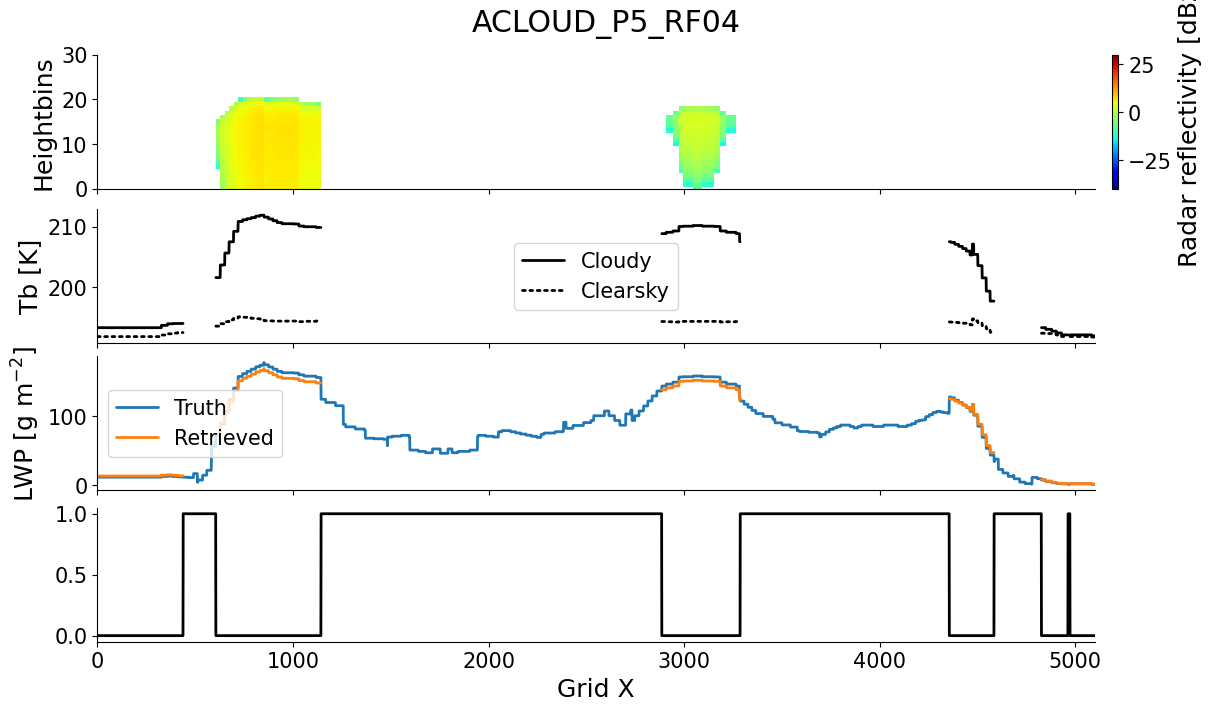

In [31]:
if pam.nmlSet['active'] == True:

    fig, axs = plt.subplots(4, 1, figsize=(12,7), sharex=True)

    im = axs[0].pcolormesh(pamtra_p5_lev.grid_x, pamtra_p5_lev.heightbins, 10*np.log10(pamtra_p5_lev.Ze).T, vmin=-40, vmax=30, cmap='jet', shading='nearest')
    fig.colorbar(im, ax=axs[0], pad=0.01, label='Radar reflectivity [dBz]')
    axs[0].set_ylim(0, 30)
    axs[0].set_ylabel('Heightbins')

    axs[1].plot(pamtra_p5_lev.grid_x,pamtra_p5_lev.tb,color='black',label='Cloudy')
    axs[1].plot(pamtra_p5_cs_lev.grid_x,pamtra_p5_cs_lev.tb,color='black',linestyle=':',label='Clearsky')
    axs[1].set_ylabel('Tb [K]')
    axs[1].legend()

    axs[2].plot(pamtra_p5_lev.grid_x,integrals[:,0]*1000,label='Truth')
    axs[2].plot(pamtra_p5_lev.grid_x,lwp_retrieved,label='Retrieved')
    axs[2].set_ylabel('LWP [g m$^{-2}$]')
    axs[2].legend()

    axs[3].plot(pamtra_p5_lev.grid_x,pam.p['sfc_type'].squeeze(),color='black')
    axs[3].set_xlabel('Grid X')

else:

    fig, axs = plt.subplots(2, 1, sharex=True)

    axs[0].plot(pamtra_p5_lev.grid_x,integrals[:,0]*1000)
    axs[0].set_ylabel('LWP [g m$^{-2}$]')

    axs[1].plot(pamtra_p5_lev.grid_x,pamtra_p5_lev.tb)
    axs[1].set_ylabel('Tb [K]')
    axs[1].set_xlabel('Grid X')

fig.suptitle(flight_id)

plt.savefig(f'/home/mringel/lwp_project/figures/retrieval_in_modelworld/{flight_id}_era5_lwp_retrieved.png',
            bbox_inches='tight',
            dpi=200)

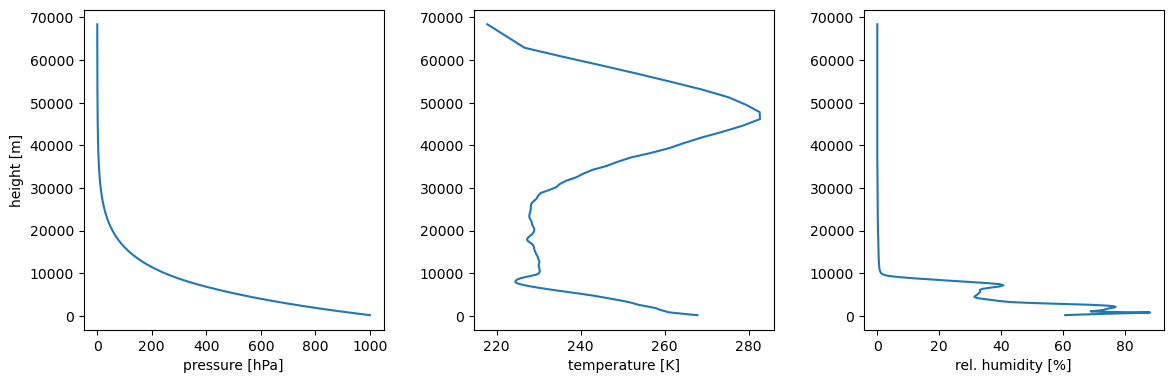

In [139]:
fig = plt.figure(figsize=[12,4])
fig.add_axes([0.1,0.1,0.25,0.8])
plt.plot(pam.p['press'][0,0,:]/100.,pam.p['hgt'][0,0,:])
plt.ylabel('height [m]')
plt.xlabel('pressure [hPa]')
fig.add_axes([0.425,0.1,0.25,0.8])
plt.plot(pam.p['temp'][0,0,:],pam.p['hgt'][0,0,:])
plt.xlabel('temperature [K]')
fig.add_axes([0.75,0.1,0.25,0.8])
plt.plot(pam.p['relhum'][0,0,:],pam.p['hgt'][0,0,:])
plt.xlabel('rel. humidity [%]')
plt.show()